In [94]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

In [90]:
flights = pd.read_csv('itineraries.csv')

flights['flightDate'] = pd.to_datetime(flights['flightDate'])
flights['day_of_week'] = flights['flightDate'].dt.day_name()

In [80]:
import re

def convert_duration_to_seconds(duration_str):
    match = re.match(r'PT(\d+)H(\d+)M', duration_str)
    if match:
        hours, minutes = map(int, match.groups())
        return hours * 3600 + minutes * 60
    else:
        return 0

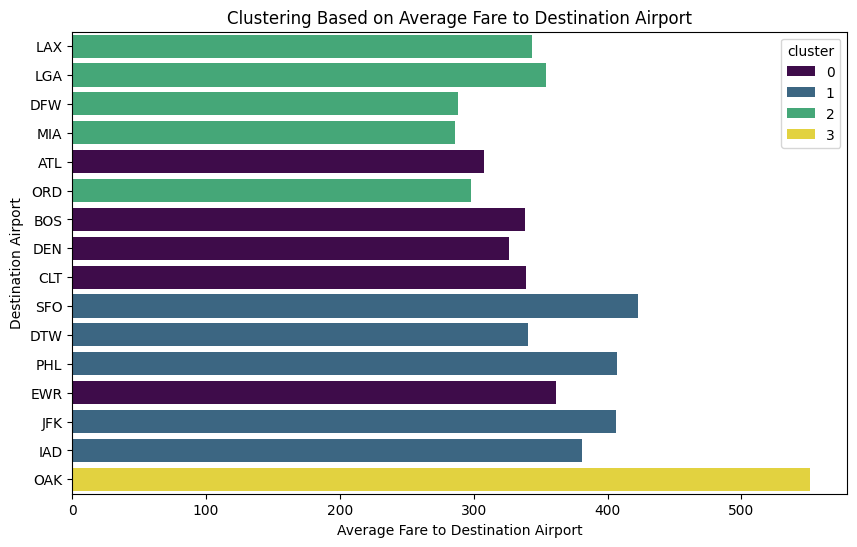

In [99]:
flights['travelDurationSeconds'] = flights['travelDuration'].apply(convert_duration_to_seconds)

# Group flights by destination airport and count the frequency of each destination
destination_counts = flights['destinationAirport'].value_counts().reset_index()
destination_counts.columns = ['destinationAirport', 'frequency']

# Add additional features
destination_counts = destination_counts.merge(flights.groupby('destinationAirport')['totalFare'].mean().reset_index(), on='destinationAirport', how='left')
destination_counts.rename(columns={'totalFare': 'avg_fare'}, inplace=True)

destination_counts = destination_counts.merge(flights.groupby('destinationAirport')['travelDurationSeconds'].mean().reset_index(), on='destinationAirport', how='left')
destination_counts.rename(columns={'travelDurationSeconds': 'avg_travel_duration_seconds'}, inplace=True)

destination_counts['airline_count'] = flights.groupby('destinationAirport')['segmentsAirlineName'].nunique().reset_index()['segmentsAirlineName']

# Standardize the numeric features
scaler = StandardScaler()
numeric_features = ['frequency', 'avg_fare', 'avg_travel_duration_seconds', 'airline_count']
destination_counts[numeric_features] = scaler.fit_transform(destination_counts[numeric_features])

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
destination_counts['cluster'] = kmeans.fit_predict(destination_counts[numeric_features])


# Revert destination_counts DataFrame to original feature values
destination_counts[numeric_features] = scaler.inverse_transform(destination_counts[numeric_features])

# Plot the clusters using the original feature values
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_fare', y='destinationAirport', hue='cluster', data=destination_counts, palette='viridis', dodge=False)
plt.xlabel('Average Fare to Destination Airport')
plt.ylabel('Destination Airport')
plt.title('Clustering Based on Average Fare to Destination Airport')
plt.show()


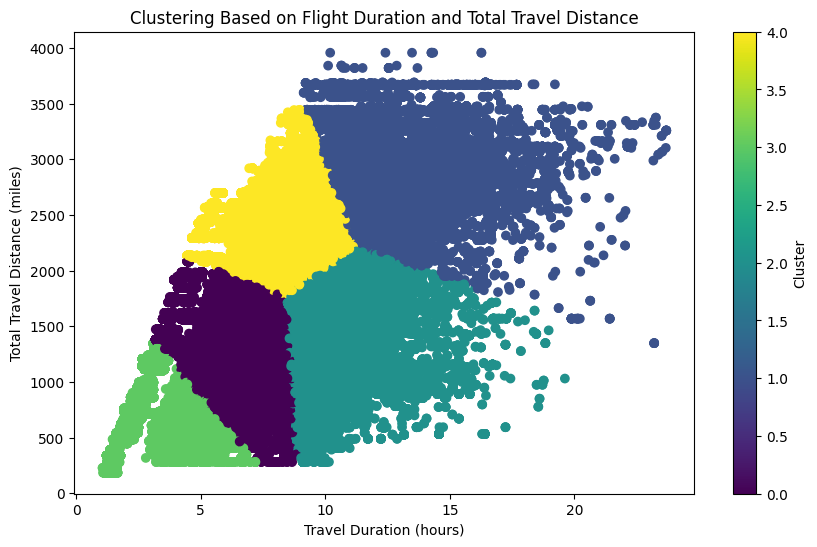

In [19]:
# Filter out flights with 0 travel duration
flights = flights[flights['travelDurationSeconds'] > 0]

# Convert travel duration from seconds to hours
flights['travelDurationHours'] = flights['travelDurationSeconds'] / 3600

# Select only numerical columns for clustering
numerical_columns = ['travelDurationHours', 'totalTravelDistance']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
scaled_data = imputer.fit_transform(flights[numerical_columns])

# Standardize the numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
flights['cluster'] = kmeans.fit_predict(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(flights['travelDurationHours'], flights['totalTravelDistance'], c=flights['cluster'], cmap='viridis')
plt.xlabel('Travel Duration (hours)')
plt.ylabel('Total Travel Distance (miles)')
plt.title('Clustering Based on Flight Duration and Total Travel Distance')
plt.colorbar(label='Cluster')
plt.show()

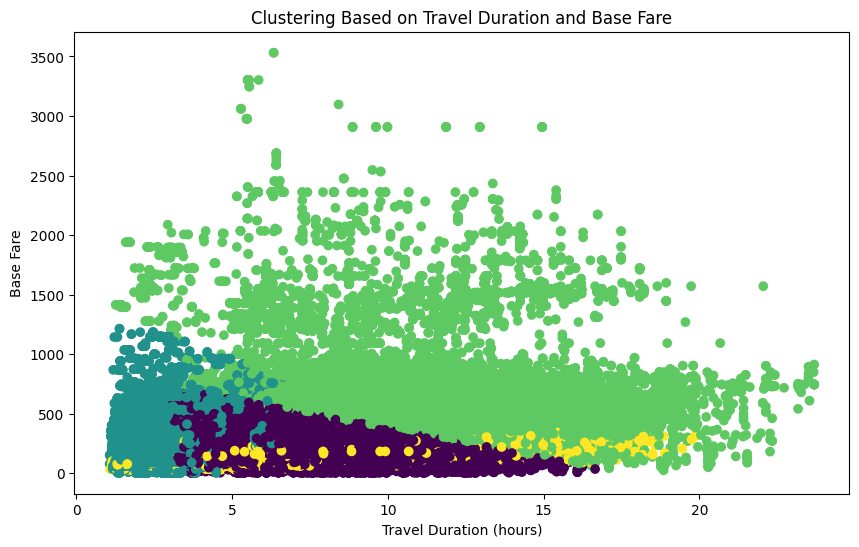

In [29]:
# Select relevant features
features_duration = ['travelDurationHours', 'baseFare', 'isBasicEconomy', 'isRefundable', 'isNonStop']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
flights_imputed = flights.copy()
flights_imputed[features_duration] = imputer.fit_transform(flights[features_duration])

# Standardize numerical features
scaled_data_duration = scaler.fit_transform(flights_imputed[features_duration])

# Apply K-means clustering
kmeans_duration = KMeans(n_clusters=5, random_state=42)
flights_imputed['cluster_duration'] = kmeans_duration.fit_predict(scaled_data_duration)

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(flights_imputed['travelDurationHours'], flights_imputed['baseFare'], c=flights_imputed['cluster_duration'], cmap='viridis')
plt.xlabel('Travel Duration (hours)')
plt.ylabel('Base Fare')
plt.title('Clustering Based on Travel Duration and Base Fare')
plt.show()

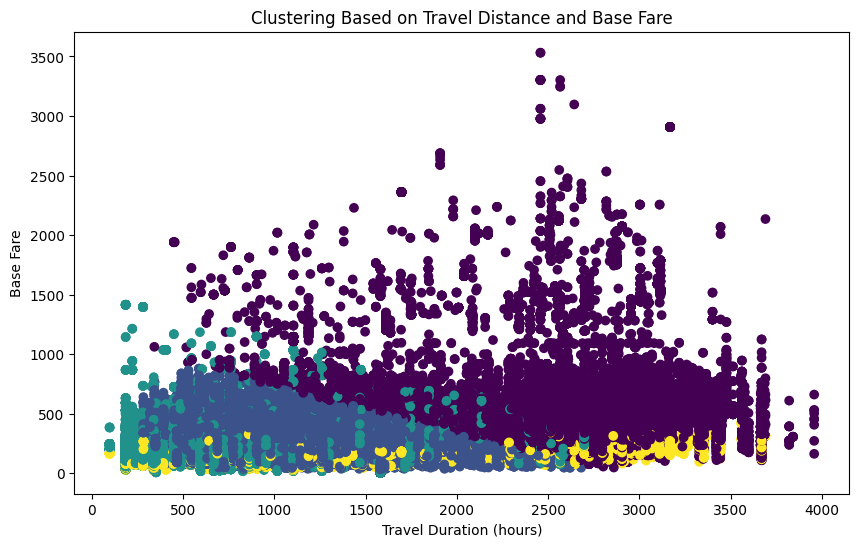

In [45]:
# Select relevant features
features_duration = ['totalTravelDistance', 'baseFare', 'isBasicEconomy', 'isRefundable', 'isNonStop']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
flights_imputed = flights.copy()
flights_imputed[features_duration] = imputer.fit_transform(flights[features_duration])

# Standardize numerical features
scaled_data_duration = scaler.fit_transform(flights_imputed[features_duration])

# Apply K-means clustering
kmeans_duration = KMeans(n_clusters=5, random_state=42)
flights_imputed['cluster_duration'] = kmeans_duration.fit_predict(scaled_data_duration)

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(flights_imputed['totalTravelDistance'], flights_imputed['baseFare'], c=flights_imputed['cluster_duration'], cmap='viridis')
plt.xlabel('Travel Duration (hours)')
plt.ylabel('Base Fare')
plt.title('Clustering Based on Travel Distance and Base Fare')
plt.show()